# day 6

このノートブックの実行例は[こちら(HTML版)](../notebooks-sample/day-4-2.html)で確認できます

---

## 0. はじめに

ページ上部のメニューバーにある **Kernel** メニューをクリックし、プルダウンメニューから [**Change Kernel ...**] を選び、**gssm2024:Python** を選択してください。

<img src="images/change_kernel1.png" width="30%">

ノートブック上部の右隅に表示されたカーネル名が **gssm2024:Python** になっていることを確認してください。

<img src="images/change_kernel2.png" width="30%">

---

## 1. テキスト分析 (演習)

#### 1.0.1 定義済み関数の読み込み

以下のセルを**修正せず**に実行してください

In [1]:
import warnings
warnings.simplefilter('ignore')

import gssm_utils

%matplotlib inline

#### 1.0.2 データの読み込み (DataFrame型)

In [2]:
import numpy as np
import pandas as pd

all_df = pd.read_csv("不具合情報一覧_20240726082240.csv")
print(all_df.shape)
display(all_df.head())

(52558, 13)


,番号,受付日,住所,申告方法,車名,初度登録年月,型式,通称名,総走行距離,原動機型式,不具合装置,発生時期,申告内容
0,1,2024年05月31日,神奈川県,ﾌﾘｰﾀﾞｲｱﾙ,日野,2013/12,QKG-FR1EXBG,プロフィア,"855,000 Km",E13C,排ｶﾞｽ･騒音,２０２０年９月１８日,ＮＯｘセンサーの不良により、ＤＰＲの作動不良が発生した。
1,2,2024年05月31日,神奈川県,ﾌﾘｰﾀﾞｲｱﾙ,日野,2018/09,2PG-FD2ABG,日野レンジャー,"429,000 Km",A05C,排ｶﾞｽ･騒音,２０２３年１２月,ＮＯｘセンサーの不良により、エンジンチェックランプが点灯した。
2,3,2024年05月31日,神奈川県,ﾌﾘｰﾀﾞｲｱﾙ,日野,2017/03,QPG-FR1EXEG,プロフィア,"824,000 Km",E13C,排ｶﾞｽ･騒音,２０２３年８月,ＮＯｘセンサーの不良により、エンジンチェックランプが点灯した。
3,4,2024年05月31日,神奈川県,ﾌﾘｰﾀﾞｲｱﾙ,日野,2018/03,2DG-FR1AHG,プロフィア,"73,200 Km",A09C,排ｶﾞｽ･騒音,２０２４年４月,ＮＯｘセンサーの不良により、エンジンチェックランプが点灯した。
4,5,2024年05月31日,神奈川県,ﾌﾘｰﾀﾞｲｱﾙ,日野,2018/09,2DG-FR1AHG,プロフィア,"707,000 Km",A09C,排ｶﾞｽ･騒音,２０２４年４月２３日,ＮＯｘセンサーの不良により、エンジンチェックランプが点灯した。


In [3]:
all_df.isna().sum()

番号            0
受付日           0
住所            0
申告方法          0
車名            2
初度登録年月     5120
型式          901
通称名         176
総走行距離      8955
原動機型式      3530
不具合装置         0
発生時期      11190
申告内容          0
dtype: int64

In [4]:
# all_df から「車名」がnanの行を削除する
all_df = all_df.dropna(subset=["車名"])

#### 1.0.3 「文書-抽出語」表 を作成する

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [5]:
# 必要ライブラリのインポート
from collections import defaultdict
import MeCab

# mecab の初期化
tagger = MeCab.Tagger("-r ../tools/usr/local/etc/mecabrc --unk-feature 未知語")

# 単語頻度辞書の初期化
word_counts = defaultdict(lambda: 0)

# 抽出語情報リストの初期化
words = []

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
# stopwords = ["湯畑"]

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, mecab で解析する
    node = tagger.parseToNode(row["申告内容"].translate(HAN2ZEN))

    # 形態素ごとのループ
    while node:
        # 解析結果を要素ごとにバラす
        features = node.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["車名"], key])

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}"
                postag = "形容動詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["車名"], key])

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["車名"], key])

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["車名"], key])

        # 次の形態素へ
        node = node.next

# DataFrme 型に整える
columns = [
    "文書ID",
    # "単語ID",
    "表層",
    "品詞",
    "車名",
    "dict_key",
]
docs_df = pd.DataFrame(words, columns=columns)

# DataFrame を表示する
print(docs_df.shape)
display(docs_df.head())

(297487, 5)


,文書ID,表層,品詞,車名,dict_key
0,1,ＮＯｘ,名詞,日野,"(ＮＯｘ, 名詞)"
1,1,センサー,名詞,日野,"(センサー, 名詞)"
2,1,不良,形容動詞,日野,"(不良, 形容動詞)"
3,1,ＤＰＲ,未知語,日野,"(ＤＰＲ, 未知語)"
4,1,不良,形容動詞,日野,"(不良, 形容動詞)"


抽出語の出現頻度をカウントする

In [6]:
# 「文書-抽出語」 表から単語の出現回数をカウントする
word_list = []
for i, (k, v) in enumerate(sorted(word_counts.items(), key=lambda x:x[1], reverse=True)):
    word_list.append((i, k[0], v, k))

# DataFrame 型に整える
columns = [
    "単語ID",
    "表層",
    "出現頻度",
    "dict_key"
]

# DataFrame を表示する
word_counts_df = pd.DataFrame(word_list, columns=columns)
print(word_counts_df.shape)
display(word_counts_df.head(10))

(10110, 4)


,単語ID,表層,出現頻度,dict_key
0,0,エンジン,19831,"(エンジン, 名詞)"
1,1,ブレーキ,8074,"(ブレーキ, 名詞)"
2,2,不良,6872,"(不良, 形容動詞)"
3,3,音,6428,"(音, 名詞)"
4,4,車,4356,"(車, 名詞)"
5,5,ペダル,4288,"(ペダル, 名詞)"
6,6,オイル,3709,"(オイル, 名詞)"
7,7,ドア,3703,"(ドア, 名詞)"
8,8,燃料,3619,"(燃料, 名詞)"
9,9,アクセル,3369,"(アクセル, 名詞)"


In [7]:
# 「単語出現回数」 表から出現回数Top 75語のみ抽出する
word_counts_75_df = word_counts_df[0:75]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_75_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_75_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "車名", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_75_df = pd.crosstab(
    [
        docs_75_df['車名'], 
        docs_75_df['文書ID']
    ],
    docs_75_df['単語ID'], margins=False
)
cross_75_df.columns = word_counts_75_df["表層"]

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(47563, 75)


表層             エンジン  ブレーキ  不良  音  車  ペダル  オイル  ドア  燃料  アクセル  ...  電動  ベルト  \
車名      文書ID                                                 ...            
M C C   14780     2     0   0  0  0    0    0   0   0     0  ...   0    0   
        26759     0     0   0  0  0    0    0   4   0     0  ...   0    0   
        27174     0     0   0  0  0    1    0   0   0     1  ...   0    0   
        29283     0     0   0  0  1    0    0   0   0     0  ...   0    0   
        33569     2     0   0  0  0    0    0   0   0     0  ...   0    0   
...             ...   ...  .. .. ..  ...  ...  ..  ..   ...  ...  ..  ...   
ＵＤトラックス 35268     0     0   0  0  1    1    0   0   0     1  ...   0    0   
        36466     0     0   0  1  0    0    0   0   0     0  ...   0    0   
        36467     0     0   0  1  0    0    0   0   0     0  ...   0    0   
        36468     2     0   0  1  0    0    0   0   0     0  ...   0    0   
        42878     0     0   0  0  0    0    0   0   0     0  ...   0    0   

表層             ルーム  タイミング  重い  前方  輪  部品  レバー  窓  
車名      文書ID                                      
M C C   14780    0      0   0   0  0   0    0  0  
        26759    0      0   0   0  0   0    0  0  
        27174    0      0   0   0  0   0    0  0  
        29283    0      0   0   0  0   0    0  0  
        33569    1      0   0   0  0   0    0  0  
...            ...    ...  ..  .. ..  ..  ... ..  
ＵＤトラックス 35268    0      0   0   0  0   0    0  0  
        36466    0      0   0   0  0   0    0  0  
        36467    0      0   0   0  0   0    0  0  
        36468    0      0   0   0  0   0    0  0  
        42878    0      0   0   0  0   0    0  0  

[47563 rows x 75 columns]

「文書-抽出語」表を {0,1} に変換する

In [8]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_75_df[cross_75_df > 0] = 1

# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df)

(47563, 75)


表層             エンジン  ブレーキ  不良  音  車  ペダル  オイル  ドア  燃料  アクセル  ...  電動  ベルト  \
車名      文書ID                                                 ...            
M C C   14780     1     0   0  0  0    0    0   0   0     0  ...   0    0   
        26759     0     0   0  0  0    0    0   1   0     0  ...   0    0   
        27174     0     0   0  0  0    1    0   0   0     1  ...   0    0   
        29283     0     0   0  0  1    0    0   0   0     0  ...   0    0   
        33569     1     0   0  0  0    0    0   0   0     0  ...   0    0   
...             ...   ...  .. .. ..  ...  ...  ..  ..   ...  ...  ..  ...   
ＵＤトラックス 35268     0     0   0  0  1    1    0   0   0     1  ...   0    0   
        36466     0     0   0  1  0    0    0   0   0     0  ...   0    0   
        36467     0     0   0  1  0    0    0   0   0     0  ...   0    0   
        36468     1     0   0  1  0    0    0   0   0     0  ...   0    0   
        42878     0     0   0  0  0    0    0   0   0     0  ...   0    0   

表層             ルーム  タイミング  重い  前方  輪  部品  レバー  窓  
車名      文書ID                                      
M C C   14780    0      0   0   0  0   0    0  0  
        26759    0      0   0   0  0   0    0  0  
        27174    0      0   0   0  0   0    0  0  
        29283    0      0   0   0  0   0    0  0  
        33569    1      0   0   0  0   0    0  0  
...            ...    ...  ..  .. ..  ..  ... ..  
ＵＤトラックス 35268    0      0   0   0  0   0    0  0  
        36466    0      0   0   0  0   0    0  0  
        36467    0      0   0   0  0   0    0  0  
        36468    0      0   0   0  0   0    0  0  
        42878    0      0   0   0  0   0    0  0  

[47563 rows x 75 columns]

#### 2.1.2 共起行列を作成する (外部変数-抽出語)

In [9]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_df = pd.concat(
    [
        cross_75_df.groupby(level='車名').sum(),
    ]
)

# DataFrame を表示する
print(aggregate_df.shape)
display(aggregate_df)

(141, 75)


表層,エンジン,ブレーキ,不良,音,車,ペダル,オイル,ドア,燃料,アクセル,...,電動,ベルト,ルーム,タイミング,重い,前方,輪,部品,レバー,窓
車名,,,,,,,,,,,,,,,,,,,,,
M C C,7,2,4,3,1,1,0,2,1,1,...,0,0,1,0,2,0,0,1,0,1
N U M M I( 生産国：アメリカ合衆国),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
T C M,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
いすゞ,277,45,105,38,37,18,97,7,66,22,...,0,2,4,2,5,2,14,8,4,6
その他,13,21,18,5,2,1,0,0,8,5,...,3,1,0,1,0,3,9,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ＭＶ ＡＧＵＳＴＡ（生産国：イタリア）,7,2,3,1,0,0,0,0,0,0,...,0,0,0,2,0,1,1,1,0,0
ＳＹＭ,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
ＴＭＴ,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.1.3 Jaccard 係数を求める (外部変数-抽出語)

In [10]:
# 抽出語の出現回数を取得する
word_counts = cross_75_df.sum(axis=0).values

# 属性(外部変数)出現数を取得する
attr_counts = np.hstack(
    [
        all_df.value_counts('車名').values,
    ]
)

# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_attrs_df = gssm_utils.jaccard_attrs_coef(aggregate_df, attr_counts, word_counts, total=51890, conditional=False)

# DataFrame を表示する
print(jaccard_attrs_df.shape)
display(jaccard_attrs_df)

(141, 75)


表層,エンジン,ブレーキ,不良,音,車,ペダル,オイル,ドア,燃料,アクセル,...,電動,ベルト,ルーム,タイミング,重い,前方,輪,部品,レバー,窓
車名,,,,,,,,,,,,,,,,,,,,,
M C C,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N U M M I( 生産国：アメリカ合衆国),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T C M,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
いすゞ,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
その他,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ＭＶ ＡＧＵＳＴＡ（生産国：イタリア）,0.000461,0.000344,0.000451,0.000170,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.002821,0.000000,0.001451,0.001493,0.001447,0.000000,0.000000
ＳＹＭ,0.000066,0.000172,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000331,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.001493,0.000000,0.001582,0.000000
ＴＭＴ,0.000066,0.000000,0.000000,0.000170,0.000260,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### 2.1.4 特徴語ランキング

In [11]:
# 「カテゴリ」や「エリア」ごとに Jaccard 係数のTop 10語を抽出する
df_list = []
for index, row in jaccard_attrs_df.iterrows():
    df_list.append(row.iloc[np.argsort(row.values)[::-1][:10]].reset_index())

# 「カテゴリ」や「エリア」ごとの Jaccard 係数のTop 10 を横方向に連結した DetaFrame を作成する
ranking_df = pd.DataFrame(pd.concat(df_list, axis=1))
ranking_df.columns = np.array([c for pair in [[x,f"jaccard"] for x in jaccard_attrs_df.index] for c in pair], dtype='object')

# DataFrame を表示する
display(ranking_df)

,M C C,jaccard,N U M M I( 生産国：アメリカ合衆国),jaccard,T C M,jaccard,いすゞ,jaccard,その他,jaccard,...,ＭＶ ＡＧＵＳＴＡ（生産国：イタリア）,jaccard,ＳＹＭ,jaccard,ＴＭＴ,jaccard,ＴＭＵＫ（生産国：イギリス）,jaccard,ＵＤトラックス,jaccard
0,窓,0.0,窓,0.0,窓,0.0,窓,0.0,窓,0.0,...,タイミング,0.002821,レバー,0.001582,フロント,0.002058,タンク,0.002632,ミッション,0.029178
1,異常,0.0,異常,0.0,異常,0.0,異常,0.0,異常,0.0,...,クラッチ,0.002210,輪,0.001493,亀裂,0.001225,シャフト,0.001389,タンク,0.020080
2,車両,0.0,車両,0.0,車両,0.0,車両,0.0,車両,0.0,...,バッテリー,0.002165,車体,0.001109,ＢＳ,0.001203,燃料,0.001255,車両,0.014335
3,ステアリング,0.0,ステアリング,0.0,ステアリング,0.0,ステアリング,0.0,ステアリング,0.0,...,輪,0.001493,クラッチ,0.001104,車体,0.001109,亀裂,0.001225,クラッチ,0.012277
4,自動,0.0,自動,0.0,自動,0.0,自動,0.0,自動,0.0,...,前方,0.001451,フロント,0.001028,助手,0.001065,モーター,0.001163,キー,0.010057
5,ポンプ,0.0,ポンプ,0.0,ポンプ,0.0,ポンプ,0.0,ポンプ,0.0,...,部品,0.001447,不能,0.000407,速度,0.001038,ポンプ,0.000653,亀裂,0.008642
6,ＣＶＴ,0.0,ＣＶＴ,0.0,ＣＶＴ,0.0,ＣＶＴ,0.0,ＣＶＴ,0.0,...,水,0.001401,道路,0.000367,ガラス,0.000968,ステアリング,0.000637,オイル,0.008525
7,エアコン,0.0,エアコン,0.0,エアコン,0.0,エアコン,0.0,エアコン,0.0,...,タンク,0.001314,アクセル,0.000331,内部,0.000942,自動,0.000608,水,0.008463
8,信号,0.0,信号,0.0,信号,0.0,信号,0.0,信号,0.0,...,モーター,0.001163,状態,0.000323,一般,0.000902,車,0.000519,シャフト,0.008392
9,左,0.0,左,0.0,左,0.0,左,0.0,左,0.0,...,フロント,0.001028,ブレーキ,0.000172,ディーラー,0.000860,オイル,0.000368,不能,0.008207


ファイルに出力する

In [12]:
ranking_df.to_csv("practice-6.tsv", sep="\t")

#### 2.1.5 ワードクラウド

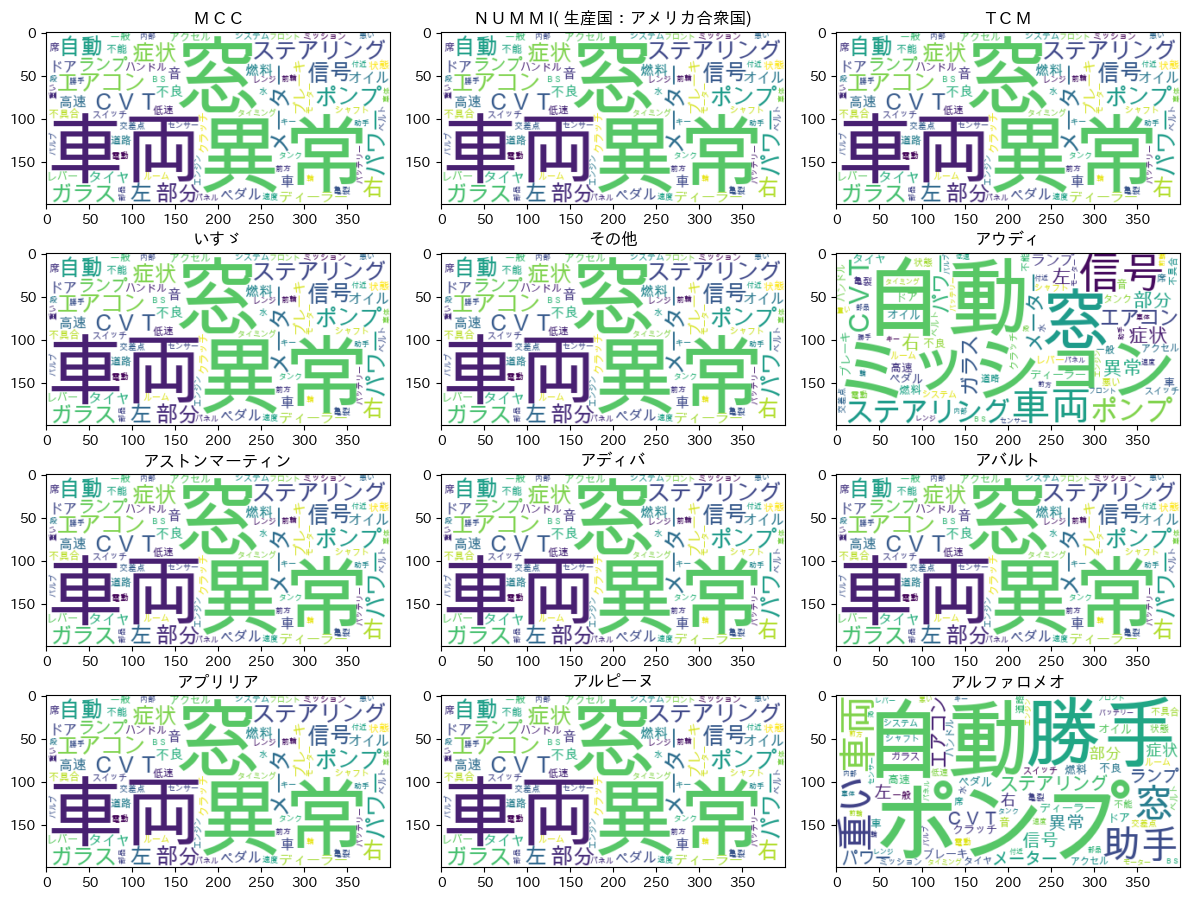

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# サブルーチン
def sort_and_plot(name, group):

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # プロットする
    ax = fig.add_subplot(4, 3, i+1)
    gssm_utils.plot_wordcloud_ax(ax, " ".join(group_cross_df.columns))
    ax.set_title(name)


# プロットの準備
fig = plt.figure(figsize=(12, 9))

i = 0
# カテゴリごとのループ
for name, group in cross_75_df.groupby(level='車名'):
    if i >= 12:
        break
    # サブルーチンを呼ぶ
    sort_and_plot(name, group)
    i += 1

# プロットの仕上げ
plt.tight_layout()
plt.show()

#### 1.7.1 共起度行列を作成する (抽出語-抽出語)

In [14]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix

# 共起行列を作成する
X = cross_75_df.values
X = csc_matrix(X)
Xc = (X.T * X)
# 対角成分のみにする
Xc = np.triu(Xc.toarray())

# DataFrame 型に整える
cooccur_75_df = pd.DataFrame(Xc, columns=cross_75_df.columns, index=cross_75_df.columns)

# DataFrame を表示する
print(cooccur_75_df.shape)
display(cooccur_75_df.head())

(75, 75)


表層,エンジン,ブレーキ,不良,音,車,ペダル,オイル,ドア,燃料,アクセル,...,電動,ベルト,ルーム,タイミング,重い,前方,輪,部品,レバー,窓
表層,,,,,,,,,,,,,,,,,,,,,
エンジン,15190,1484,2281,1977,1033,1475,1596,140,938,1405,...,176,225,652,524,187,103,47,164,130,19
ブレーキ,0,5819,530,518,873,1772,120,27,28,503,...,121,17,24,30,130,301,179,75,118,4
不良,0,0,6656,828,346,372,230,225,458,364,...,172,50,84,76,90,34,73,102,61,39
音,0,0,0,5881,304,358,249,209,81,338,...,54,135,285,147,46,70,146,111,37,84
車,0,0,0,0,3853,639,96,182,139,531,...,45,36,45,33,30,217,45,42,82,25


#### 1.7.2 Jaccard 係数を求める (抽出語-抽出語)

In [15]:
# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_75_df = gssm_utils.jaccard_coef(cooccur_75_df, cross_75_df)

# DataFrame を表示する
print(jaccard_75_df.shape)
display(jaccard_75_df.head())

(75, 75)


表層,エンジン,ブレーキ,不良,音,車,ペダル,オイル,ドア,燃料,アクセル,...,電動,ベルト,ルーム,タイミング,重い,前方,輪,部品,レバー,窓
表層,,,,,,,,,,,,,,,,,,,,,
エンジン,0.0,0.076005,0.116586,0.103540,0.057357,0.085314,0.097830,0.007961,0.056357,0.083596,...,0.011183,0.014403,0.042712,0.034079,0.011873,0.006529,0.002972,0.010435,0.008284,0.001207
ブレーキ,0.0,0.000000,0.044370,0.046324,0.099216,0.232515,0.014253,0.003242,0.003422,0.060326,...,0.018841,0.002632,0.003680,0.004616,0.020199,0.048494,0.028368,0.011655,0.018633,0.000626
不良,0.0,0.000000,0.000000,0.070715,0.034045,0.037736,0.025148,0.025092,0.053318,0.039081,...,0.023862,0.006884,0.011508,0.010425,0.012307,0.004651,0.010065,0.014079,0.008441,0.005425
音,0.0,0.000000,0.000000,0.000000,0.032238,0.039354,0.029813,0.025463,0.009888,0.039463,...,0.008243,0.021084,0.045074,0.022812,0.006989,0.010769,0.022795,0.017180,0.005713,0.013189
車,0.0,0.000000,0.000000,0.000000,0.000000,0.094137,0.014822,0.029322,0.022764,0.083701,...,0.009929,0.008046,0.009923,0.007285,0.006565,0.050173,0.010049,0.009329,0.018624,0.005682


#### 1.7.3 プロットする

<Figure size 800x800 with 0 Axes>

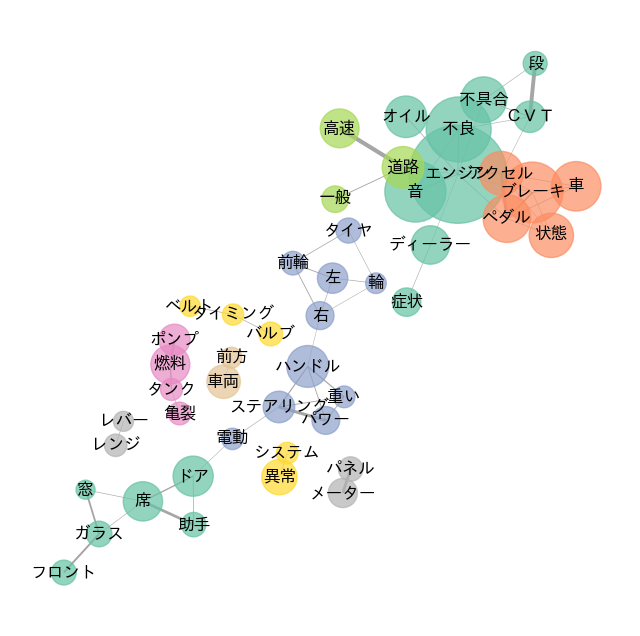

In [16]:
# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 共起行列(Jaccard係数)で共起ネットワーク図を作成する
gssm_utils.plot_cooccur_network(jaccard_75_df, word_counts, np.sort(jaccard_75_df.values.reshape(-1))[::-1][60])

### 1.8 係り受けネットワーク図 

#### 1.8.1 係り受け行列を作成する

In [17]:
# チャンク(文節)から単語を取り出す
def get_words(tree, from_chunk, stopwords):

    # チャンク(文節)の開始位置を取得する
    beg = from_chunk.token_pos

    # チャンクの開始位置を取得する
    end = from_chunk.token_pos + from_chunk.token_size

    # 抽出語情報リストの初期化
    words = []

    # チャンク(文節)ごとのループ
    for i in range(beg, end):

        # チャンク中の形態素を取り出す
        token = tree.token(i)

        # 解析結果を要素ごとにバラす
        features = token.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}だ"
                postag = "形容動詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 抽出語情報をリストに追加する
                words.append(key)

    # 抽出語情報をリストを返却する
    return words


# 必要ライブラリのインポート
import CaboCha

# cabocha の初期化
cp = CaboCha.Parser("-r ../tools/usr/local/etc/cabocharc")

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ['*']  # 原形に 「'*'」 が出力された場合に除去するため

# 係り受けペア辞書の初期化
pair_counts = defaultdict(lambda: 0)
pairs = []

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, cabocha で解析する
    tree = cp.parse(row["申告内容"].translate(HAN2ZEN))

    # 解析結果から空でないチャンク(文節)のリストを集める
    chunks = {}
    key = 0
    for i in range(tree.size()):
        tok = tree.token(i)
        if tok.chunk:
            chunks[key] = tok.chunk
            key += 1

    # 係り元と係り先の単語情報(原形と品詞)を集める
    for from_chunk in chunks.values():
        # 係り先がなければスキップ
        if from_chunk.link < 0:
            continue

        # 係り先のチャンク(文節)を取得する
        to_chunk = chunks[from_chunk.link]

        # 係り元の単語情報(原形と品詞)を取得する
        from_words = get_words(tree, from_chunk, stopwords)

        # 係り先の単語情報(原形と品詞)を取得する
        to_words = get_words(tree, to_chunk, stopwords)

    # 係り受けペアと頻度を収集する
    for f in from_words:
        for t in to_words:
            key = (f[0], t[0])
            pair_counts[key] += 1


# 係り受け行列を初期化する (共起行列と同じ形)
Xd = np.zeros(cooccur_75_df.shape)

# 係り受けペアを係り受け列に変換する
for (f,t), v in pair_counts.items():
    columns = list(cooccur_75_df.columns)
    if f in columns and t in columns:
        i = columns.index(f)
        j = columns.index(t)
        Xd[i,j] = v

# DataFrme 型に整える
dep_75_df = pd.DataFrame(Xd, columns=cooccur_75_df.columns, index=cooccur_75_df.columns)
print(dep_75_df.shape)
display(dep_75_df.head())

(75, 75)


表層,エンジン,ブレーキ,不良,音,車,ペダル,オイル,ドア,燃料,アクセル,...,電動,ベルト,ルーム,タイミング,重い,前方,輪,部品,レバー,窓
表層,,,,,,,,,,,,,,,,,,,,,
エンジン,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ブレーキ,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0
不良,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
音,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
車,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### 1.8.2 条件付き確率を求める

In [18]:
# 係り受け行列の中身(numpy行列)を取り出す
Xc = dep_75_df.values

# 係り受け行列(条件付き確率)を初期化する (元の係り受け行列と同じ形)
Xd = np.zeros(Xc.shape)

# 係り元単語の出現頻度を取得する
word_counts = cooccur_75_df.sum(axis=0).values

# 係り受けペアごとのループ
for (f,t), v in pair_counts.items():
    columns = list(dep_75_df.columns)

    # 係り元と係り先の両方が列に含まれる
    if f in columns and t in columns:
        i = columns.index(f)
        j = columns.index(t)

        # 条件付き確率(係り受け頻度/係り先出現回数)を求める
        Xd[i,j] = v / word_counts[i]

# DataFrame 型に整える
dep_75_df = pd.DataFrame(Xd, columns=dep_75_df.columns, index=dep_75_df.columns)

# DataFrame を表示する
print(dep_75_df.shape)
display(dep_75_df.head())

(75, 75)


表層,エンジン,ブレーキ,不良,音,車,ペダル,オイル,ドア,燃料,アクセル,...,電動,ベルト,ルーム,タイミング,重い,前方,輪,部品,レバー,窓
表層,,,,,,,,,,,,,,,,,,,,,
エンジン,0.0,0.0,0.0,0.0,0.0,0.0,0.000132,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ブレーキ,0.0,0.0,0.0,0.0,0.0,0.0,0.000137,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.002054,0.0,0.0,0.0,0.0,0.0
不良,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
音,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
車,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000156,0.0,0.0,0.0,0.0,0.0


#### 1.8.3 プロットする

pyvis.html


<Figure size 800x800 with 0 Axes>

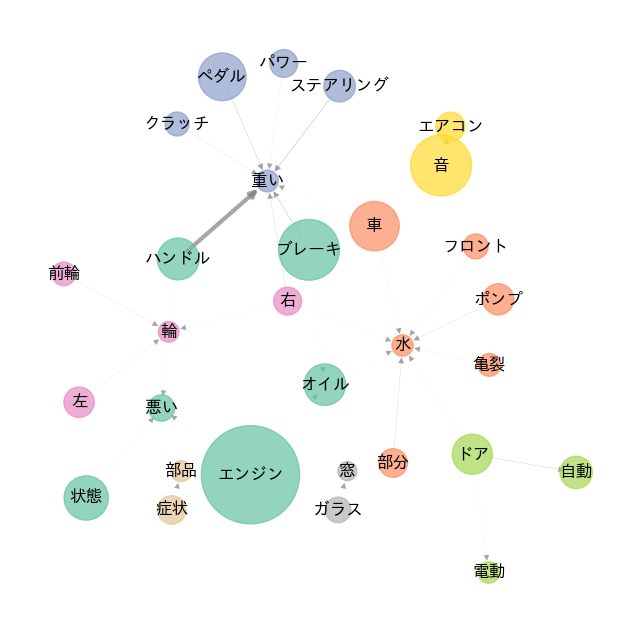

In [19]:
# 抽出語の出現回数(ノードの大きさ)を取得する
word_counts = cross_75_df.sum(axis=0).values

# 係り受け(条件付き確率)で共起ネットワーク図を作成する
gssm_utils.plot_dependency_network(dep_75_df, word_counts, np.sort(dep_75_df.values.reshape(-1))[::-1][60], pyvis=True)

### 1.9 対応分析

「文書-抽出語」 表を確認する

In [20]:
# DataFrame を表示する
print(cross_75_df.shape)
display(cross_75_df.head())

(47563, 75)


表層           エンジン  ブレーキ  不良  音  車  ペダル  オイル  ドア  燃料  アクセル  ...  電動  ベルト  ルーム  \
車名    文書ID                                                 ...                 
M C C 14780     1     0   0  0  0    0    0   0   0     0  ...   0    0    0   
      26759     0     0   0  0  0    0    0   1   0     0  ...   0    0    0   
      27174     0     0   0  0  0    1    0   0   0     1  ...   0    0    0   
      29283     0     0   0  0  1    0    0   0   0     0  ...   0    0    0   
      33569     1     0   0  0  0    0    0   0   0     0  ...   0    0    1   

表層           タイミング  重い  前方  輪  部品  レバー  窓  
車名    文書ID                                 
M C C 14780      0   0   0  0   0    0  0  
      26759      0   0   0  0   0    0  0  
      27174      0   0   0  0   0    0  0  
      29283      0   0   0  0   0    0  0  
      33569      0   0   0  0   0    0  0  

[5 rows x 75 columns]

#### 1.9.1 「外部変数-抽出語」 クロス集計表を作成する

In [21]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_75_df = pd.concat(
    [
        cross_75_df.groupby(level='車名').sum(), 
    ]
)

# DataFrame を表示する
print(aggregate_75_df.shape)
display(aggregate_75_df)

(141, 75)


表層,エンジン,ブレーキ,不良,音,車,ペダル,オイル,ドア,燃料,アクセル,...,電動,ベルト,ルーム,タイミング,重い,前方,輪,部品,レバー,窓
車名,,,,,,,,,,,,,,,,,,,,,
M C C,7,2,4,3,1,1,0,2,1,1,...,0,0,1,0,2,0,0,1,0,1
N U M M I( 生産国：アメリカ合衆国),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
T C M,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
いすゞ,277,45,105,38,37,18,97,7,66,22,...,0,2,4,2,5,2,14,8,4,6
その他,13,21,18,5,2,1,0,0,8,5,...,3,1,0,1,0,3,9,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ＭＶ ＡＧＵＳＴＡ（生産国：イタリア）,7,2,3,1,0,0,0,0,0,0,...,0,0,0,2,0,1,1,1,0,0
ＳＹＭ,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
ＴＭＴ,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 1.9.2 対応分析プロットを作成する

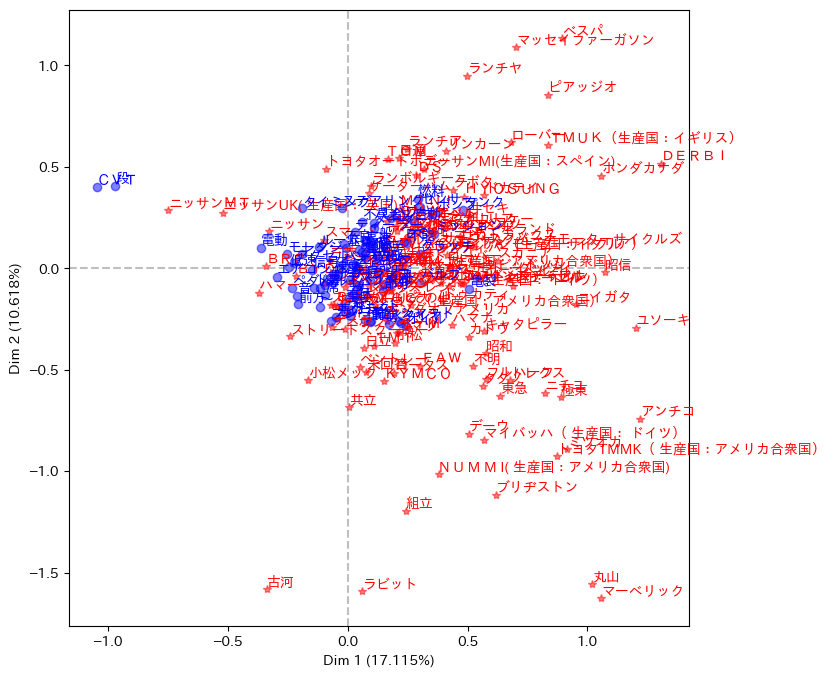

In [22]:
# 必要ライブラリのインポート
import mca

# ライブラリ mca による対応分析
ncols = aggregate_75_df.shape[1]
mca_ben = mca.MCA(aggregate_75_df, ncols=ncols, benzecri=False)

# 行方向および列方向の値を取り出す
row_coord = mca_ben.fs_r(N=2)
col_coord = mca_ben.fs_c(N=2)

# 固有値を求める
eigenvalues = mca_ben.L
total = np.sum(eigenvalues)
# 寄与率を求める
explained_inertia = 100 * eigenvalues / total

# 行方向および列方向のラベルを取得する
row_labels = aggregate_75_df.index
col_labels = aggregate_75_df.columns

# プロットする
gssm_utils.plot_coresp(row_coord, col_coord, row_labels, col_labels, explained_inertia)

#### 2.1.6 共起ネットワーク図 (カテゴリ)

In [23]:
# 抽出語の出現回数を取得する
word_counts = cross_75_df.sum(axis=0).values

# 属性(外部変数)出現数を取得する
attr_counts = np.hstack(
    [
        all_df.value_counts('車名').values,
    ]
)

# カテゴリのみの共起行列(共起度数)を取得する
# df = aggregate_df.loc[["A_レジャー","B_ビジネス"],:]
df = aggregate_df.loc[all_df["車名"].unique(),:]

# 共起行列(共起度数)で共起ネットワーク図を作成する
gssm_utils.plot_attrs_network(df, attr_counts, word_counts, np.sort(df.values.reshape(-1))[::-1][60], width=8, height=8, pyvis=True)

KeyError: "['川崎（大特）'] not in index"

#### 2.1.8 トピックを抽出する (LDA)

In [ ]:
# 必要ライブラリのインポート
from sklearn.decomposition import LatentDirichletAllocation as LDA

# ライブラリ LDA によるトピック抽出
lda = LDA(max_iter=25, learning_method='batch', random_state=42, n_jobs=-1, n_components=6)
lda.fit(cross_75_df.values)

# トピックごとに出現確率Top 20語を表示する
n_top_words = 20
feature_names = cross_75_df.columns
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic # {topic_idx+1}:", end=" ")
    for i in topic.argsort()[:-n_top_words-1:-1]:
        print(feature_names[i], end=" ")
    print()

ChatGPT を使ってトピックを説明する

プロンプトの例:
> 以下はトピックとトピックごとの高確率ワードです. これを読んで各トピックの要約を日本語で作成してください.
> 
> Topic # 1	フロント ホテル 浴場 部屋 親切だ 良い …

結果の例:
- トピック 1: ホテルの立地と利便性
- トピック 2: ホテルの食事とスタッフのサービス
- トピック 3: ホテルの部屋と風呂
- トピック 4: 温泉と風呂
- トピック 5: ホテルの全体的な評価
- トピック 6: 子連れ家族の滞在

In [ ]:
# トピックごとに出現確率Top 75語をプロットする
n_top_words = 75
gssm_utils.plot_topic_model(lda, feature_names, n_top_words)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# サブルーチン
def sort_and_plot(name, group):

    # 文書ごとのトピック比率を取得
    doc_topic_distributions = lda.transform(group.values)

    # 文書全体のトピック比率を計算（平均を取る）
    overall_topic_distribution = np.mean(doc_topic_distributions, axis=0)

    # プロットする
    ax = fig.add_subplot(4, 3, i+1)
    gssm_utils.plot_topic_distribution_ax(ax, overall_topic_distribution)
    ax.set_title(name)

# プロットの準備
fig = plt.figure(figsize=(12, 9))

i = 0
# カテゴリごとのループ
for name, group in cross_75_df.groupby(level='車名'):
    if i >= 12:
        break
    # サブルーチンを呼ぶ
    sort_and_plot(name, group)
    i += 1

# プロットの仕上げ
plt.tight_layout()
plt.show()